In [439]:
import sys
import os

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))

import numpy as np
import torch
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot, spin_system_plot
from population import time_population, tr_utils, transform
import population

from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from reader import read_bruker_data
from spectra_manager import BaseSpectraCreator, StationarySpectraCreator

import optimization
import spectra_processing

import save_procedures

reload(spectral_integration)
reload(spin_system)
reload(population)
reload(population.stationary_population)

reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)
reload(mesher.general_mesh)
reload(mesher)
reload(mesher.delanay_neigbour)


reload(spin_system_plot)
reload(save_procedures)

<module 'save_procedures' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\save_procedures.py'>

In [440]:
reload(optimization.fitter)
reload(optimization.objectives)

<module 'optimization.objectives' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\optimization\\objectives.py'>

### TEST RESFIELD ALGORITHM

In [441]:
class ResFieldTestCtreator(StationarySpectraCreator):
    def forward(self,
             sample: spin_system.MultiOrientedSample,
             fields: torch.Tensor):

        B_low  = fields[..., 0].unsqueeze(-1).expand(*self.mesh_size)
        B_high = fields[..., -1].unsqueeze(-1).expand(*self.mesh_size)

        F, Gx, Gy, Gz = sample.get_hamiltonian_terms()

        (vectors_u, vectors_v), (valid_lvl_down, valid_lvl_up), res_fields, resonance_energies, full_eigen_vectors =\
            self.res_field(sample, self.resonance_freq, B_low, B_high, F, Gz)

        return None

In [442]:
def _get_one_spin_system(mesh_size):
    e_1 = particles.Electron(spin=0.5)
    g_1 = spin_system.Interaction((2, 2.0, 2.0))
    
    
    system = spin_system.SpinSystem([e_1], g_tensors=(g_1, ))
    mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=mesh_size)
    sample = spin_system.MultiOrientedSample(system)
    return sample

def _get_midium_system_anisotropy(mesh_size):
    e_1 = particles.Electron(spin=1)
    e_2 = particles.Electron(spin=0.5)
    
    g_1 = spin_system.Interaction((2, 2.2, 2.3))
    g_2 = spin_system.Interaction((2, 2.1, 2.1))
    
    J = constants.unit_converter(123, "Hz_to_K")

    ee = spin_system.Interaction(J)
    zer = spin_system.Interaction(J)
    
    system = spin_system.SpinSystem([e_1, e_2], g_tensors=(g_1, g_2), electron_electron=[(0, 1, ee), (0, 0, zer)])
    mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=mesh_size)
    sample = spin_system.MultiOrientedSample(system)
    return sample


def _get_large_spin_system(mesh_size):
    e_1 = particles.Electron(spin=1)
    e_2 = particles.Electron(spin=0.5)
    e_3 = particles.Electron(spin=0.5)
    e_4 = particles.Electron(spin=0.5)
    
    g_1 = spin_system.Interaction((2, 2.2, 2.3))
    g_2 = spin_system.Interaction((2, 2.1, 2.1))
    g_3 = spin_system.Interaction((2, 2.1, 2.1))
    g_4 = spin_system.Interaction((2, 2.1, 2.1))
    
    J = constants.unit_converter(123, "Hz_to_K")

    ee = spin_system.Interaction(J)
    zer = spin_system.Interaction(J)
    
    system = spin_system.SpinSystem([e_1, e_2, e_3, e_4], g_tensors=(g_1, g_2, g_3, g_4), electron_electron=[(0, 1, ee), (0, 0, zer)])
    mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=mesh_size)
    sample = spin_system.MultiOrientedSample(system, mesh=mesh)
    return sample


def _get_large_spin_system(mesh_size):
    e_1 = particles.Electron(spin=1)
    e_2 = particles.Electron(spin=0.5)
    e_3 = particles.Electron(spin=0.5)
    e_4 = particles.Electron(spin=0.5)
    
    g_1 = spin_system.Interaction((2, 2.2, 2.3))
    g_2 = spin_system.Interaction((2, 2.1, 2.1))
    g_3 = spin_system.Interaction((2, 2.1, 2.1))
    g_4 = spin_system.Interaction((2, 2.1, 2.1))
    
    J = constants.unit_converter(123, "Hz_to_K")

    ee = spin_system.Interaction(J)
    zer = spin_system.Interaction(J)
    system = spin_system.SpinSystem([e_1, e_2, e_3, e_4], g_tensors=(g_1, g_2, g_3, g_4), electron_electron=[(0, 1, ee), (0, 0, zer)])
    mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=mesh_size)
    sample = spin_system.MultiOrientedSample(system, mesh=mesh)
    return sample

In [443]:
g_1 = spin_system.Interaction((2, 2.2, 2.3))

In [444]:
sample = _get_one_spin_system(12)
freq = 9.8 * 1e9

In [445]:
res_filed_creator = ResFieldTestCtreator(freq, sample)

In [446]:
solver = res_field_algorithm.ZeroFreeResonanceIntervalSolver(sample.base_spin_system.spin_system_dim)

In [447]:
sample = _get_large_spin_system(35)

In [448]:
F, Gx, Gy, Gz = sample.get_hamiltonian_terms()
resonance_frequency = torch.tensor(9.8 * 1e9)

def _compute_zero_field_resonance(F: torch.tensor, resonance_frequency: torch.tensor):
    """
    :param F: Magnetic filed free stationary Hamiltonian matrix. The shape is [..., K, K],
    where K is spin system dimension
    :param resonance_frequency: the resonance frequency. The shape is []
    :return: The mask, where True if resonance function > 0, and False otherwise
    """
    eig_values = torch.linalg.eigvalsh(F)
    res_1N = eig_values[..., -1] - eig_values[..., 0] - resonance_frequency
    return res_1N > 0

baseline_sigh = _compute_zero_field_resonance(F, resonance_frequency)
fields = torch.linspace(0.2, 0.4, 100)
B_low  = fields[..., 0].unsqueeze(-1).expand(*sample.mesh.initial_size)
B_high = fields[..., -1].unsqueeze(-1).expand(*sample.mesh.initial_size)

deriv_max = sample.calculate_derivative_max()



#solver = torch.compile(solver)

In [449]:
solver_jit = torch.jit.trace(solver, example_inputs=(F, Gz, B_low, B_high, resonance_frequency, baseline_sigh, deriv_max), optimize=True)

RuntimeError: Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions

In [428]:
with torch.no_grad():
    start_time = time.perf_counter()
    for _ in range(100):
        out = solver_jit(F, Gz, B_low, B_high, resonance_frequency, baseline_sigh, deriv_max)
end_time = time.perf_counter()
print( (end_time - start_time) / (100 * 1_000))

0.0001830564909998793


In [437]:
with torch.no_grad():
    start_time = time.perf_counter()
    for _ in range(100):
        out = solver(F, Gz, B_low, B_high, resonance_frequency, baseline_sigh, deriv_max)
end_time = time.perf_counter()
print( (end_time - start_time) / (100 * 1_000))

0.00017666233399999328


In [ ]:
import time


def pergorm_test(size, caller):
    sample = caller(size)
    freq = 9.8 * 1e9
    res_filed_creator = ResFieldTestCtreator(freq, sample)
    field = torch.linspace(0.2, 0.4, 100)
    
    with torch.no_grad():
        start_time = time.perf_counter()
        for _ in range(100):
            out = res_filed_creator(sample, field)
    end_time = time.perf_counter()
    return (end_time - start_time) / (100 * 1_000)
    

def test_time():
    mesh_size = [4, 10, 35]
    sample_callers = {"small": _get_one_spin_system, "mid": _get_midium_system_anisotropy, "large": _get_large_spin_system}
    for size in mesh_size:
        for key, caller in sample_callers.items():
            time_res= pergorm_test(size, caller)
            print(f"mesh_size {size},  caller: {key}   time_res  {time_res}  \n")
            

In [290]:
test_time()

mesh_size 4,  caller: small   time_res  6.041440999979386e-06  

mesh_size 4,  caller: mid   time_res  1.8355890999955592e-05  

mesh_size 4,  caller: large   time_res  1.5588530999957584e-05  

mesh_size 10,  caller: small   time_res  4.959438999940175e-06  

mesh_size 10,  caller: mid   time_res  1.705377699996461e-05  

mesh_size 10,  caller: large   time_res  3.918790100011392e-05  

mesh_size 35,  caller: small   time_res  4.962060999969253e-06  

mesh_size 35,  caller: mid   time_res  1.7039685999916402e-05  

mesh_size 35,  caller: large   time_res  0.0003020541170000797  



In [83]:
test_time()

mesh_size 4,  caller: small   time_res  5.523212999978568e-06  

mesh_size 4,  caller: mid   time_res  1.7080153999850153e-05  

mesh_size 4,  caller: large   time_res  1.5484939999878408e-05  

mesh_size 10,  caller: small   time_res  5.237669000052847e-06  

mesh_size 10,  caller: mid   time_res  1.6853238999901805e-05  

mesh_size 10,  caller: large   time_res  3.927236599993193e-05  

mesh_size 35,  caller: small   time_res  5.343236000044271e-06  

mesh_size 35,  caller: mid   time_res  1.663185400015209e-05  

mesh_size 35,  caller: large   time_res  0.00028711276099988026  



In [90]:
test_time()

mesh_size 4,  caller: small   time_res  5.451970000285655e-06  

mesh_size 4,  caller: mid   time_res  1.7488123000075575e-05  

mesh_size 4,  caller: large   time_res  1.6060929000086618e-05  

mesh_size 10,  caller: small   time_res  5.257455999962985e-06  

mesh_size 10,  caller: mid   time_res  1.7043966999917758e-05  

mesh_size 10,  caller: large   time_res  3.940499200019986e-05  

mesh_size 35,  caller: small   time_res  5.384164999995846e-06  

mesh_size 35,  caller: mid   time_res  1.7212063999904786e-05  

mesh_size 35,  caller: large   time_res  0.0002808384050001041  



In [34]:
data = torch.randn(100, 4, 200, 200)
idx_true = torch.randint(100, (50, ))
idx_false = torch.randint(100, (50, ))

In [35]:
def vers_1():
    data_true = data.index_select(dim=0, index=idx_true)
    data_false = data.index_select(dim=0, index=idx_false)
    return data_true, data_false
    
def vers_2():
    idx = torch.cat((idx_true, idx_false), dim=0)
    reordered = data.index_select(dim=0, index=idx)
    n_true = idx_true.shape[0]
    data_1 = reordered[:n_true]
    data_2 = reordered[n_true:]  
    return data_1, data_2
    

In [64]:
e_1 = particles.Electron(spin=0.5)
e_2 = particles.Electron(spin=1.5)
g_1 = spin_system.Interaction((2, 2.0, 2.0))
g_2 = spin_system.Interaction((2, 2.0, 2.0))

J = constants.unit_converter(123, "Hz_to_K")

ee = spin_system.Interaction(J)
zer = spin_system.Interaction(J)


system = spin_system.SpinSystem([e_1, e_2], g_tensors=(g_1, g_2), electron_electron=[(0, 1, ee), (0, 0, zer)])
sample = spin_system.MultiOrientedSample(system)


In [65]:
spin_system.SpinSystem()

TypeError: SpinSystem.__init__() missing 2 required positional arguments: 'electrons' and 'g_tensors'

In [66]:
def build_sample(
    J, g_cu_chain, g_cu_branching, orient_side, orient_up, mesh, gauss, lorentz
) -> spin_system.MultiOrientedSample:

        # g-tensor components
        g_cu_chain_tensor = torch.tensor(g_cu_chain)
        g1_frame = orient_side
        zeem_chain = spin_system.Interaction(
            g_cu_chain_tensor, g1_frame)
        
        g_cu_branching = torch.tensor(g_cu_branching)
        orient_up = orient_up
        zeem_branching = spin_system.Interaction(g_cu_branching, orient_up)
        
        e_chain = particles.Electron(spin=0.5)
        e_branching = particles.Electron(spin=0.5)
        
        J = 2 * J # Because 2 S1 S2
        J = (J * 100) * 3 * 1e8
        J = torch.full((3,), J)
        d_frame = torch.zeros(3)
        ee_int_chain = spin_system.Interaction(J, d_frame, torch.zeros(3))
        
        system = spin_system.SpinSystem(
            electrons=[e_chain, e_branching],
            g_tensors=[zeem_chain, zeem_branching],
            electron_electron=[
                (0, 1, ee_int_chain)
            ]
        )

        # Homogeneity strain
        
        return system, spin_system.MultiOrientedSample(system, torch.tensor([0, 4e8, 0.0]), gauss, lorentz, mesh)

In [67]:
orien_side_up = torch.tensor(
    [
        [0.8859114, 0.0008034, 0.4638538],
        [0.0005397, -0.9999996, 0.0007013],
        [0.4638541, -0.000371, -0.8859115],]
)

orien_chain_left = torch.tensor(
    [
        [0.744169, 0.4552341, -0.4888501],
        [0.3236334, -0.8859029, -0.3323212],
        [-0.5843577, 0.0890949, -0.8065904]
    ]
)


J = -0.02
g_cu_chain = [2.0, 2.1, 2.2]
g_cu_branching = [2.3, 2.14, 2.17]
gauss = torch.tensor(0.0)
lorentz = torch.tensor(0.01)
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2* np.pi),
                                    initial_grid_frequency=35,
                                    interpolate=False)

#mesh = mesher.CrystalMesh(torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.1, 0.0]]))

system, sample = build_sample(J, g_cu_chain, g_cu_branching, orien_side_up, orien_chain_left, mesh, gauss, lorentz)


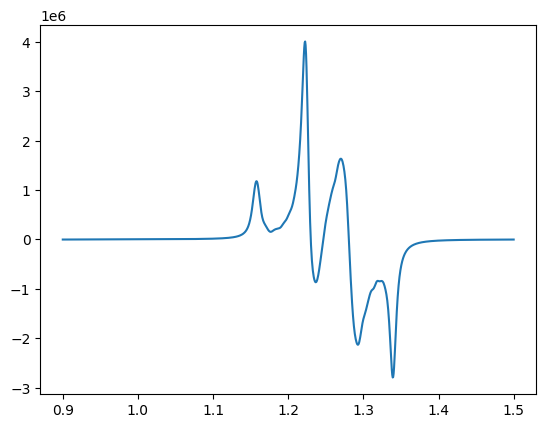

In [68]:
fields_1 = torch.linspace(0.9, 1.5, 1_000)
freq = torch.tensor(38 * 1e9)
temp = 0.1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)
    
plt.plot(fields_1.numpy(), spec_1.numpy())

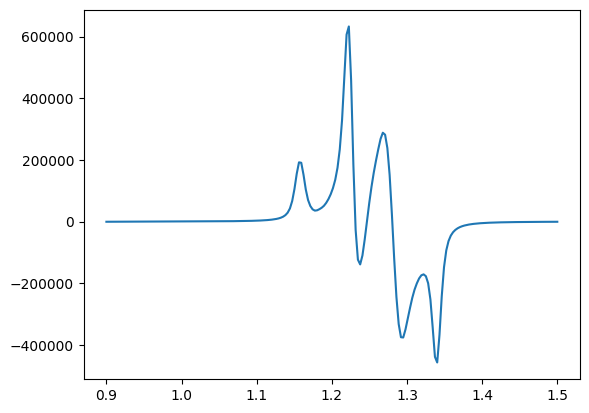

In [69]:
fields_1 = torch.linspace(0.9, 1.5, 200)
freq = torch.tensor(38 * 1e9)
temp = 0.1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_1 = spec_creat(sample, fields_1)
    
plt.plot(fields_1.numpy(), spec_1.numpy())

In [775]:
save_procedures.save("example.mat", sample, spec_creat, fields_1, "easyspin")
sample, fields_1, spec_creat = save_procedures.load("example.mat", "easyspin").values()

In [776]:
print(sample)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=0.5
  e1: S=0.5

Nuclei: None

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 4
Configuration shape: ()

INTERACTIONS (1 total):
------------------------------

Electron-Electron (1):
  1. e0 ↔ e1:
      Principal values: [-1200000000.0000, -1200000000.0000, -1200000000.0000]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None


GENERAL INFO: 
lorentz: 0.009999999776482582
gauss: 0.0
gauss: tensor([[0.0000e+00, 0.0000e+00, 4.0000e+08]])


In [705]:
import time
start_time = time.perf_counter()

for _ in range(300):
    with torch.no_grad():
        spec_1 = spec_creat(sample, fields_1)
        
end_time = time.perf_counter()
print((end_time - start_time) / 100 * 1000)

TypeError: 'str' object is not callable

In [ ]:
start_time = time.perf_counter()

for _ in range(300):
    with torch.no_grad():
        spec_1 = spec_creat(sample, fields_1)
        
end_time = time.perf_counter()
print((end_time - start_time) / 100 * 1000)

In [614]:
from torch.profiler import profile, ProfilerActivity, record_function

#with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
#    with record_function("model_inference"):
#        spec_1 = spec_creat(sample, freq, fields_1)

In [ ]:
#print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

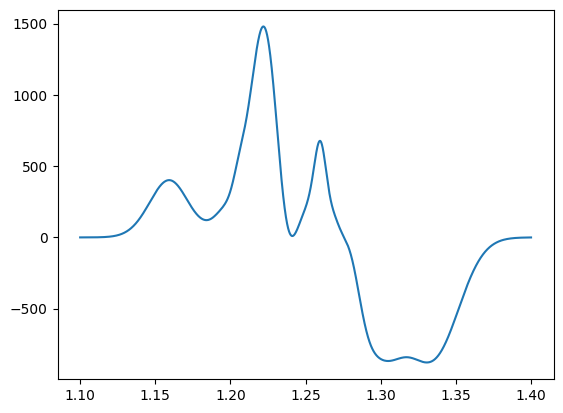

In [208]:
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)

fields_2 = torch.linspace(1.10, 1.4, 4400)
freq = torch.tensor(38 * 1e9)
temp = 0.1
spec_creat = spectra_manager.StationarySpectraCreator(freq, sample, temperature=temp)
with torch.no_grad():
    spec_2 = spec_creat(sample, fields_2)
    
plt.plot(fields_2.numpy(), spec_2.numpy())

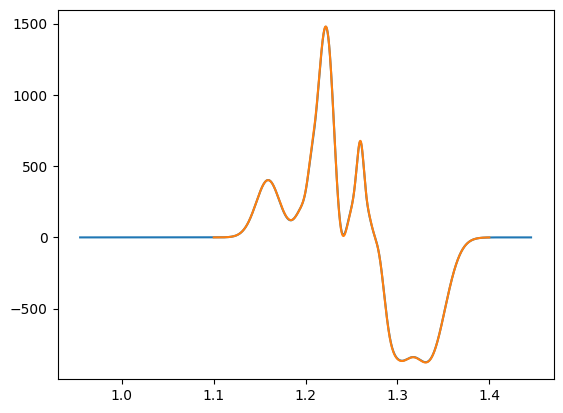

In [209]:
plt.plot(fields_1.numpy()[400:-400], spec_1.numpy()[400:-400])
plt.plot(fields_2.numpy(), spec_2.numpy())

In [154]:
mesh = mesher.DelaunayMeshNeighbour(phi_limits = (0, 1.999 * np.pi),
                                    initial_grid_frequency=4,
                                    interpolate=False)

vertices, triangles = mesh.post_mesh
areas = mesh.spherical_triangle_areas(vertices, triangles)

In [504]:
def rotation_matrix_to_zyz_euler(R):
    """
    Convert a 3x3 rotation matrix to ZYZ Euler angles.
    
    Args:
        R (torch.Tensor): 3x3 rotation matrix
    
    Returns:
        tuple: (alpha, beta, gamma) in radians
               alpha: rotation around Z-axis (first)
               beta: rotation around Y-axis (middle) 
               gamma: rotation around Z-axis (last)
    """
    # Extract elements from rotation matrix
    r11, r12, r13 = R[0, 0], R[0, 1], R[0, 2]
    r21, r22, r23 = R[1, 0], R[1, 1], R[1, 2]
    r31, r32, r33 = R[2, 0], R[2, 1], R[2, 2]
    
    # Calculate beta (middle rotation around Y-axis)
    beta = torch.acos(torch.clamp(r33, -1.0, 1.0))
    
    # Check for singularities
    sin_beta = torch.sin(beta)
    
    if torch.abs(sin_beta) > 1e-6:  # Non-singular case
        # Calculate alpha (first rotation around Z-axis)
        alpha = torch.atan2(r23, r13)
        
        # Calculate gamma (last rotation around Z-axis)
        gamma = torch.atan2(r32, -r31)
    else:
        # Singular case: beta ≈ 0 or π
        if torch.abs(beta) < 1e-6:  # beta ≈ 0
            # When beta ≈ 0, only alpha + gamma is determined
            alpha = torch.atan2(r12, r11)
            gamma = torch.tensor(0.0, dtype=R.dtype, device=R.device)
        else:  # beta ≈ π
            # When beta ≈ π, only alpha - gamma is determined
            alpha = torch.atan2(-r12, r11)
            gamma = torch.tensor(0.0, dtype=R.dtype, device=R.device)
    
    return alpha, beta, gamma

In [507]:
a, b, gamma = rotation_matrix_to_zyz_euler(system.g_tensors[0].frame)

In [509]:
system.g_tensors[0].frame

tensor([[ 8.8591e-01,  8.0340e-04,  4.6385e-01],
        [ 5.3970e-04, -1.0000e+00,  7.0130e-04],
        [ 4.6385e-01, -3.7100e-04, -8.8591e-01]])

In [508]:
utils.euler_angles_to_matrix(torch.tensor([a, b, gamma]))

tensor([[[ 8.8591e-01,  8.0334e-04,  4.6385e-01],
         [ 5.3960e-04, -1.0000e+00,  7.0130e-04],
         [ 4.6385e-01, -3.7099e-04, -8.8591e-01]]])

In [1277]:
zero_areas = (areas == 0).numpy()

In [1278]:
vertices_np = vertices.numpy()
triangles_np = triangles.numpy()

In [1279]:
from matplotlib import pyplot as plt

In [ ]:
plt.triplot(vertices_np[:, 0], vertices_np[:, 1], triangles.numpy()[zero_areas])

In [ ]:
vertices_np

array([[0.        , 0.        ],
       [0.        , 0.62831855],
       [6.2800436 , 0.62831855],
       [0.        , 0.9424778 ],
       [3.1400218 , 0.9424778 ],
       [6.2800436 , 0.9424778 ],
       [0.        , 1.2566371 ],
       [2.0933478 , 1.2566371 ],
       [4.1866956 , 1.2566371 ],
       [6.2800436 , 1.2566371 ],
       [0.        , 1.5707964 ],
       [1.5700109 , 1.5707964 ],
       [3.1400218 , 1.5707964 ],
       [4.710033  , 1.5707964 ],
       [6.2800436 , 1.5707964 ]], dtype=float32)

In [ ]:
    def spherical_triangle_areas(vertices: torch.Tensor, triangles: torch.Tensor):
        """
        vertices: tensor of shape (N,2), each row is [phi, theta]
        triangles: tensor of shape (M,3) with indices into vertices defining the triangles.

        Returns:
           areas: tensor of shape (M,) with the spherical areas of the triangles (for unit sphere).
                  For a sphere of radius R, multiply each area by R**2.
        """
        def _angle_between(u, v):
            dot = (u * v).sum(dim=1)
            dot = torch.clamp(dot, -1.0, 1.0)
            return torch.acos(dot)
        phi = vertices[:, 0]
        theta = vertices[:, 1]
        

        x = torch.sin(theta) * torch.cos(phi)
        y = torch.sin(theta) * torch.sin(phi)
        z = torch.cos(theta)
        xyz = torch.stack([x, y, z], dim=1)

        v0 = xyz[triangles[:, 0]]
        v1 = xyz[triangles[:, 1]]
        v2 = xyz[triangles[:, 2]]

        a = _angle_between(v1, v2)
        b = _angle_between(v2, v0)
        c = _angle_between(v0, v1)

        s = (a + b + c) / 2

        # L'Huilier's formula for spherical excess
        tan_E_4 = torch.sqrt(
            torch.clamp(
                torch.tan(s / 2) * torch.tan((s - a) / 2) * torch.tan((s - b) / 2) * torch.tan((s - c) / 2),
                min=0.0
            )
        )

        excess = 4 * torch.atan(tan_E_4)
        return excess

In [16]:
import torch
from typing import List, Optional

import torch
from typing import List

import torch
from typing import List, Optional

def split_positions_unique(idx: torch.Tensor, num_buckets: Optional[int] = None) -> List[torch.Tensor]:
    if idx.numel() == 0:
        return []
    if idx.dim() != 1:
        raise ValueError("idx must be a 1D tensor")
    
    # Get unique values, inverse indices, and counts
    u, inverse, counts = torch.unique(idx, return_inverse=True, return_counts=True)
    max_count = counts.max().item()
    if num_buckets is None:
        num_buckets = max_count
    if num_buckets < max_count:
        raise ValueError(f"num_buckets ({num_buckets}) < required minimal buckets ({max_count})")
    
    # Compute group start indices
    group_start = torch.cat([torch.tensor([0], device=idx.device), counts.cumsum(0)[:-1]])
    
    # Sort indices by inverse and compute occurrence index
    sorted_indices = torch.argsort(inverse)
    sorted_inverse = inverse[sorted_indices]
    occurrence_index_sorted = torch.arange(len(idx), device=idx.device) - group_start[sorted_inverse]
    occurrence_index = torch.empty_like(occurrence_index_sorted)
    occurrence_index[sorted_indices] = occurrence_index_sorted
    
    # Group indices by occurrence index using bincount and split
    counts_per_bucket = torch.bincount(occurrence_index, minlength=num_buckets)
    sorted_by_bucket = torch.argsort(occurrence_index)
    buckets_tensors = torch.split(sorted_by_bucket, counts_per_bucket.tolist())
    
    return list(buckets_tensors)

In [19]:
indexes = torch.tensor([1,2,3,4,5,6,1,2,3,4,5,1,1,2,3,4,56])
sub_indexes = split_positions_unique(indexes)

In [ ]:
indexes.select_indexes(sub_indexes)

In [2]:
import torch

In [4]:
delta = torch.tensor(2*3.14 / 6)

In [5]:
theta_1 = torch.tensor(3.14 / 5)
theta_2 = torch.tensor(3.14 / 8)

In [9]:
cos_a = torch.cos(theta_1).square() + torch.sin(theta_1).square() * torch.cos(delta)

cos_c = torch.cos(theta_2).square() + torch.sin(theta_2).square() * torch.cos(delta)

cos_b = torch.cos(theta_1) * torch.cos(theta_2) + torch.sin(theta_1) * torch.sin(theta_2) * torch.cos(delta / 2)

In [13]:
a, b, c = torch.acos(cos_a), torch.acos(cos_b), torch.acos(cos_c)

In [141]:
def _get_L(n, m):
    return (2 * n - 1) * m + m*(m-1)/2

In [ ]:
n = 3
m = 5
L = _get_L(n, m)
factors = [0] + [((2 * (n + k) - 1) / L) for k in  range(1, m)]

In [153]:
a = torch.tensor([1,2,3])

In [154]:
a[:1]

tensor([1])

In [155]:
a[1:]

tensor([2, 3])

In [156]:
a.tolist()

[1, 2, 3]

In [179]:
idx

tensor([4, 3, 2, 3, 4, 0])

In [180]:
idx_1 = torch.randint(5, (2, ))
idx_2 = torch.randint(5, (4, ))
idx = torch.cat((idx_1, idx_2), dim=0)

a = torch.randn(5, 100, 20)
a = a.index_select(dim=0, index=idx)
n = idx_1.numel()

In [181]:
a[:n].shape, a[n:].shape

(torch.Size([2, 100, 20]), torch.Size([4, 100, 20]))

In [58]:
idx = torch.tensor([], dtype=torch.long)

In [43]:
idx = torch.tensor([2,3,4])
min_idx = idx[0]
max_idx = idx[1]

In [55]:
a[(min_idx-1):(max_idx+1)].shape

torch.Size([3, 100, 20])

In [53]:
a[1:].shape

torch.Size([4, 100, 20])